In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import itertools
from collections import Counter
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for file in os.listdir(root_dir):
            if file.lower().endswith('.jpg'):
                path = os.path.join(root_dir, file)
                try:
                    class_num = int(file.split('_')[0])
                    label = class_num - 1
                    self.image_paths.append(path)
                    self.labels.append(label)
                except Exception as e:
                    print(f"Skipping file {file}: {e}")

        assert len(self.image_paths) > 0, f"No valid image files found in {root_dir}"
        print(f"Loaded {len(self.image_paths)} images from {root_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
from google.colab import drive
drive.mount('/content/drive')

train_root = '/content/drive/My Drive/Project1/train'
val_root = '/content/drive/My Drive/Project1/val'


from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = ImageDataset(train_root, transform=train_transform)

y_train = [label for _, label in train_dataset]

class_counts = Counter(y_train)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in y_train]
print (len(sample_weights))
print(f"Sample weights: {sample_weights}")

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=0)

val_dataset = ImageDataset(val_root, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 3000 images from /content/drive/My Drive/Project1/train
3000
Sample weights: [0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.000482392667631452, 0.00048239266763

In [4]:
len(train_loader.dataset), len(val_loader.dataset)  # Check the number of images in train and val datasets

(3000, 1000)

In [5]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of labels: {len(train_dataset.labels)}")
print(f"Number of classes: {len(set(train_dataset.labels))}")
print(f"Classes: {set(train_dataset.labels)}")

Number of training samples: 3000
Number of validation samples: 1000
Number of labels: 3000
Number of classes: 7
Classes: {0, 1, 2, 3, 4, 5, 6}


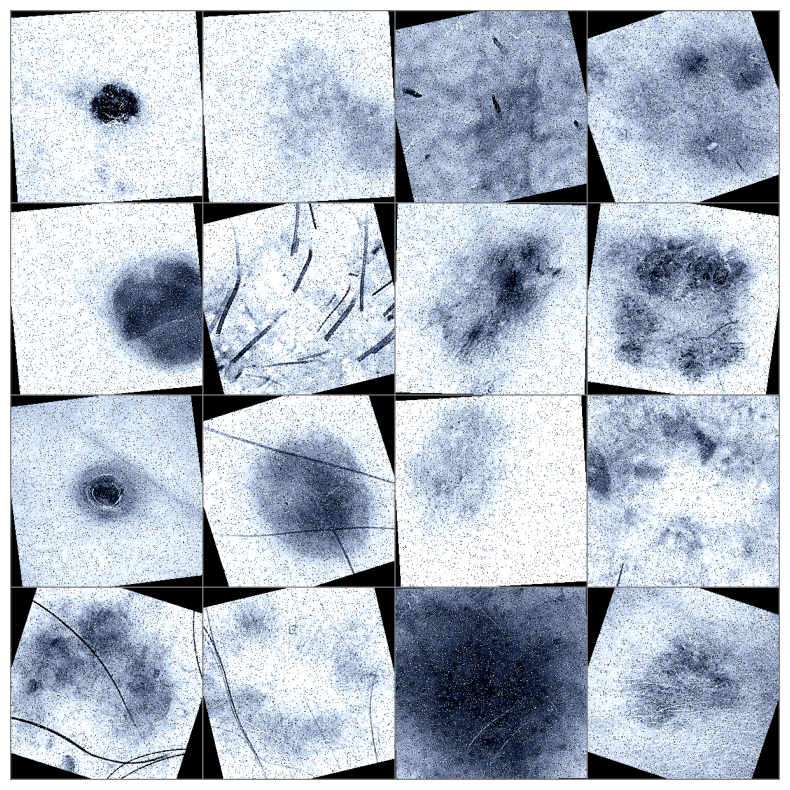

In [6]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(vutils.make_grid(images[:16], nrow=4))

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v3_large', pretrained=True )
model.classifier[3] = torch.nn.Linear(in_features=model.classifier[3].in_features, out_features=7)
#print(model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct_val / total_val

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Plotting the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plotting the accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()


In [9]:
num_classes = len(class_counts)
total_samples = sum(class_counts.values())

# Create per-class weights (inverse frequency)
class_weights = [total_samples / class_counts[i] for i in range(num_classes)]
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print(f"Class weights: {class_weights_tensor}")

Class weights: tensor([26.7857, 20.2703,  8.7464, 83.3333, 11.8577,  1.4472, 85.7143],
       device='cuda:0')


Training started!
Epoch [1/20], Train Loss: 1.4351, Train Accuracy: 46.80%, Val Loss: 1.5319, Val Accuracy: 41.50%
Epoch [2/20], Train Loss: 0.9761, Train Accuracy: 63.90%, Val Loss: 1.2652, Val Accuracy: 51.60%
Epoch [3/20], Train Loss: 0.8099, Train Accuracy: 70.73%, Val Loss: 1.3234, Val Accuracy: 49.20%
Epoch [4/20], Train Loss: 0.7339, Train Accuracy: 72.87%, Val Loss: 1.1085, Val Accuracy: 61.10%
Epoch [5/20], Train Loss: 0.6179, Train Accuracy: 77.20%, Val Loss: 0.8801, Val Accuracy: 69.40%
Epoch [6/20], Train Loss: 0.5361, Train Accuracy: 80.63%, Val Loss: 0.9942, Val Accuracy: 62.40%
Epoch [7/20], Train Loss: 0.5022, Train Accuracy: 81.50%, Val Loss: 1.0881, Val Accuracy: 62.20%
Epoch [8/20], Train Loss: 0.4267, Train Accuracy: 83.97%, Val Loss: 0.8487, Val Accuracy: 69.70%
Epoch [9/20], Train Loss: 0.3711, Train Accuracy: 86.93%, Val Loss: 0.9423, Val Accuracy: 66.30%
Epoch [10/20], Train Loss: 0.3577, Train Accuracy: 86.97%, Val Loss: 0.8165, Val Accuracy: 73.50%
Epoch [11/2

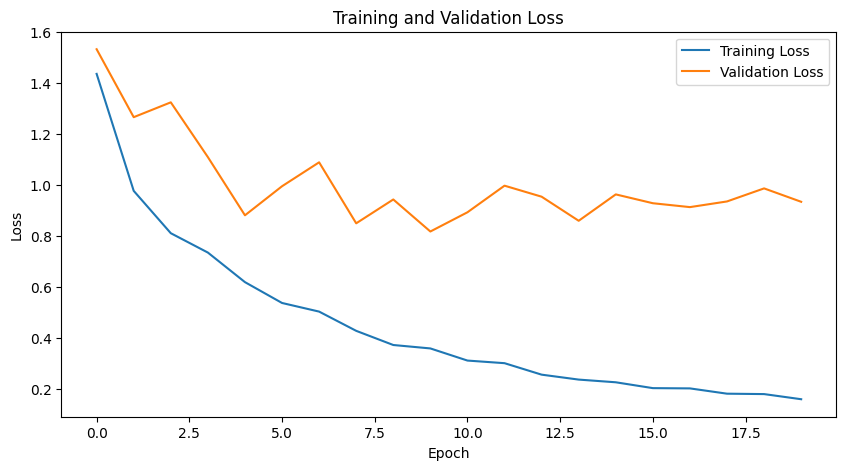

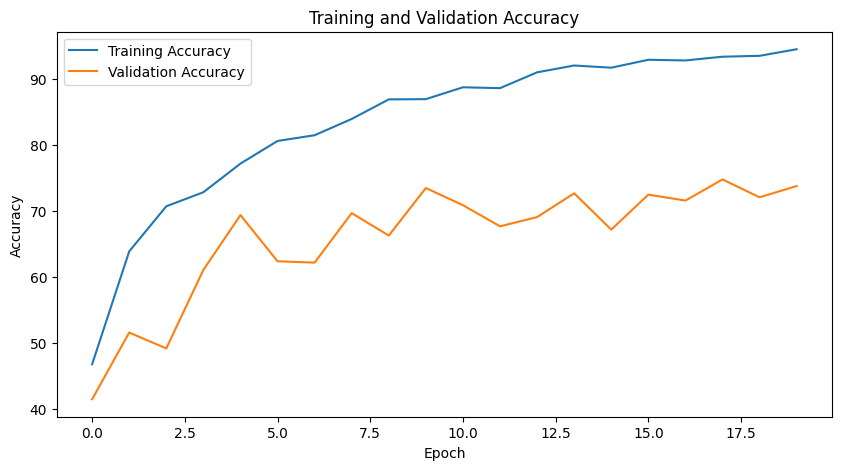

In [10]:
#train the model, show progress bar
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
print("Training started!")
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

Validation Accuracy: 73.80%
              precision    recall  f1-score   support

           0       0.48      0.44      0.46        36
           1       0.64      0.42      0.51        60
           2       0.44      0.68      0.53       102
           3       0.14      0.07      0.09        15
           4       0.43      0.36      0.39        97
           5       0.87      0.87      0.87       670
           6       0.53      0.40      0.46        20

    accuracy                           0.74      1000
   macro avg       0.51      0.46      0.47      1000
weighted avg       0.74      0.74      0.73      1000



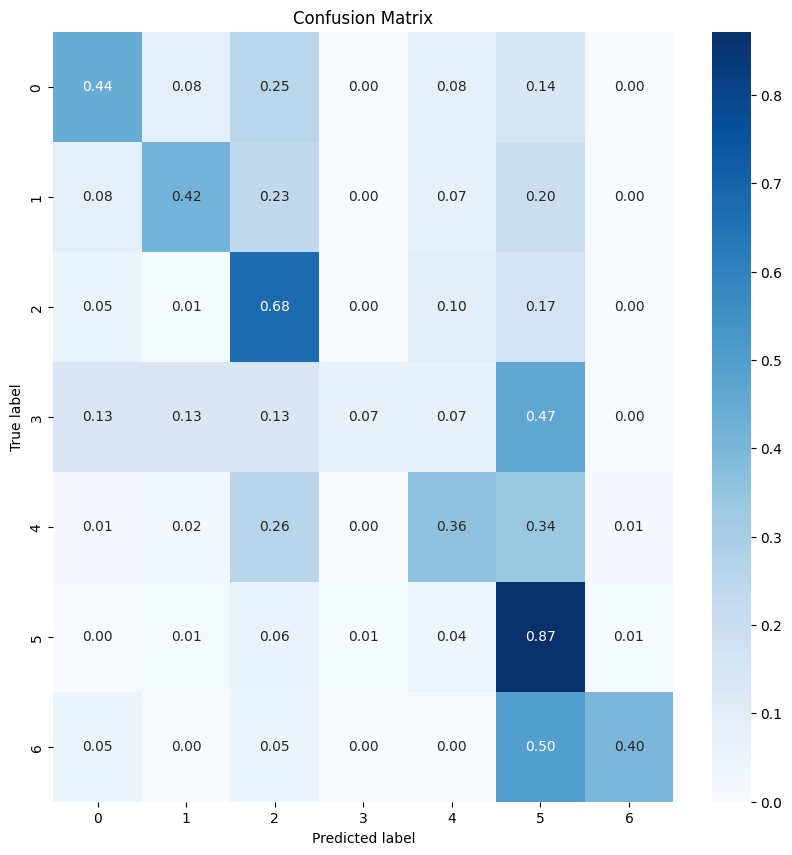

Accuracy for class 0: 0.44
Accuracy for class 1: 0.42
Accuracy for class 2: 0.68
Accuracy for class 3: 0.07
Accuracy for class 4: 0.36
Accuracy for class 5: 0.87
Accuracy for class 6: 0.40


In [11]:
#check if the model is trained
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(len(set(train_dataset.labels)))]))


def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate and print per-class accuracy
    for i in range(len(classes)):
        class_accuracy = cm[i, i]
        print(f"Accuracy for class {classes[i]}: {class_accuracy:.2f}")

plot_confusion_matrix(y_true, y_pred, classes=list(set(train_dataset.labels)))

# Save the model
torch.save(model.state_dict(), 'skin_cancer_model.pth')

In [12]:
test_root = '/content/drive/My Drive/project/test'

test_dataset = ImageDataset(val_root, transform=val_transform)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)


#check if the model is trained
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"test Accuracy: {accuracy:.2f}%")

y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(len(set(train_dataset.labels)))]))

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_true, y_pred, classes=list(set(train_dataset.labels)))

# Save the model
torch.save(model.state_dict(), 'skin_cancer_model.pth')

(3000, 1000)

In [28]:
model1 = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True )

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
num_classes = len(class_counts)
total_samples = sum(class_counts.values())

# Create per-class weights (inverse frequency)
class_weights = [total_samples / class_counts[i] for i in range(num_classes)]
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print(f"Class weights: {class_weights_tensor}")

Class weights: tensor([26.7857, 20.2703,  8.7464, 83.3333, 11.8577,  1.4472, 85.7143],
       device='cuda:0')


Training started!
Epoch [1/25], Train Loss: 3.1505, Train Accuracy: 39.50%, Val Loss: 1.8169, Val Accuracy: 46.10%
Epoch [2/25], Train Loss: 1.2315, Train Accuracy: 58.53%, Val Loss: 1.1409, Val Accuracy: 57.60%
Epoch [3/25], Train Loss: 1.0420, Train Accuracy: 62.10%, Val Loss: 1.0502, Val Accuracy: 62.60%
Epoch [4/25], Train Loss: 0.9329, Train Accuracy: 64.47%, Val Loss: 1.0834, Val Accuracy: 62.20%
Epoch [5/25], Train Loss: 0.8340, Train Accuracy: 69.80%, Val Loss: 0.9674, Val Accuracy: 66.90%
Epoch [6/25], Train Loss: 0.7498, Train Accuracy: 72.13%, Val Loss: 0.8256, Val Accuracy: 70.00%
Epoch [7/25], Train Loss: 0.6810, Train Accuracy: 75.07%, Val Loss: 1.1259, Val Accuracy: 60.60%
Epoch [8/25], Train Loss: 0.6551, Train Accuracy: 75.27%, Val Loss: 0.8770, Val Accuracy: 69.30%
Epoch [9/25], Train Loss: 0.6344, Train Accuracy: 76.67%, Val Loss: 0.9026, Val Accuracy: 72.80%
Epoch [10/25], Train Loss: 0.5586, Train Accuracy: 78.93%, Val Loss: 0.9348, Val Accuracy: 68.10%
Epoch [11/2

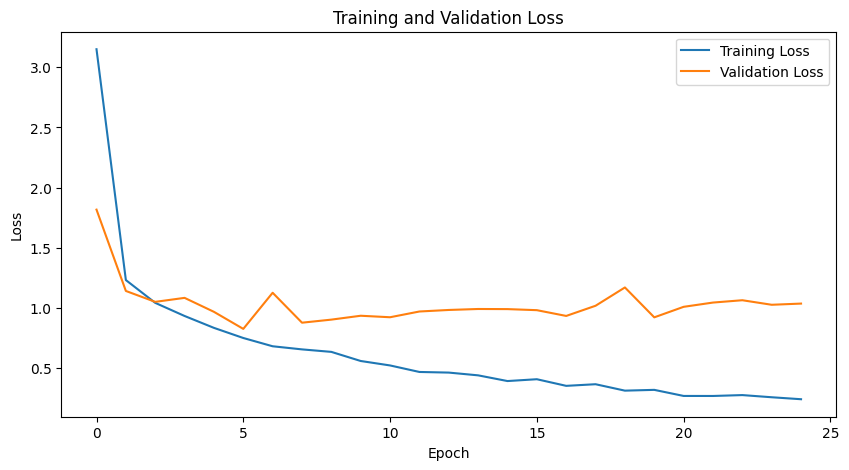

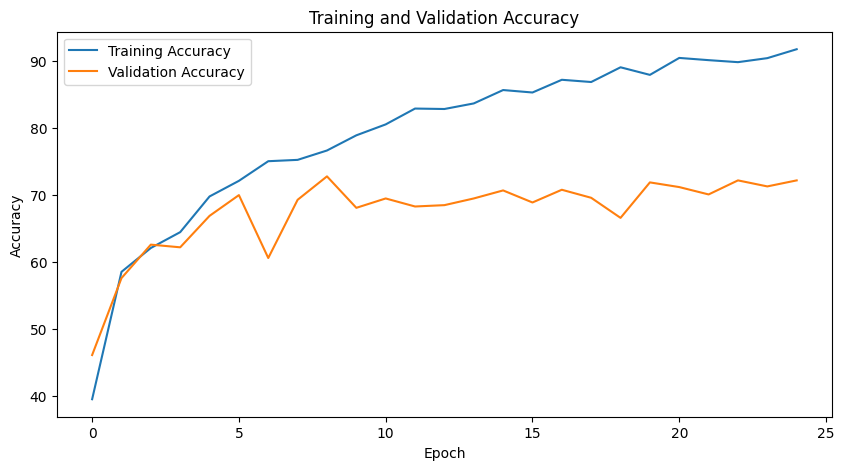

In [30]:
#train the model, show progress bar
model = model1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
print("Training started!")
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)

Validation Accuracy: 72.20%
              precision    recall  f1-score   support

           0       0.40      0.53      0.45        36
           1       0.48      0.65      0.55        60
           2       0.47      0.58      0.52       102
           3       0.36      0.27      0.31        15
           4       0.41      0.53      0.46        97
           5       0.92      0.81      0.86       670
           6       0.38      0.50      0.43        20

    accuracy                           0.72      1000
   macro avg       0.49      0.55      0.51      1000
weighted avg       0.76      0.72      0.74      1000



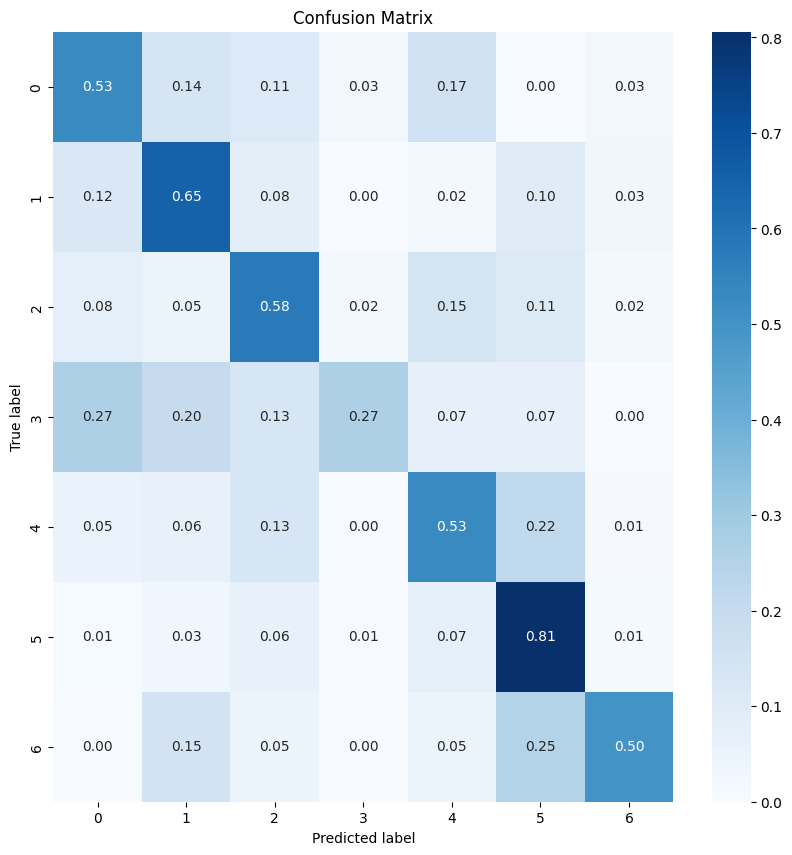

Accuracy for class 0: 0.53
Accuracy for class 1: 0.65
Accuracy for class 2: 0.58
Accuracy for class 3: 0.27
Accuracy for class 4: 0.53
Accuracy for class 5: 0.81
Accuracy for class 6: 0.50


In [31]:
#check if the model is trained
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(len(set(train_dataset.labels)))]))


def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate and print per-class accuracy
    for i in range(len(classes)):
        class_accuracy = cm[i, i]
        print(f"Accuracy for class {classes[i]}: {class_accuracy:.2f}")

plot_confusion_matrix(y_true, y_pred, classes=list(set(train_dataset.labels)))

# Save the model
torch.save(model.state_dict(), 'skin_cancer_model.pth')

In [32]:

# Corrected Hard Example Mining (Hard Data Mining) Section

# Step 1: Identify misclassified images by filepath
def get_misclassified_paths(model, dataset, device):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for i in range(len(dataset)):
            image, label = dataset[i]
            input_tensor = image.unsqueeze(0).to(device)
            output = model(input_tensor)
            _, pred = torch.max(output, 1)
            if pred.item() != label:
                misclassified.append((dataset.image_paths[i], label))
    return misclassified

# Step 2: Define dataset that can reload images from file paths
class HardExampleDataset(Dataset):
    def __init__(self, image_label_list, transform=None):
        self.data = image_label_list
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Step 3: Get misclassified training examples and prepare DataLoader
misclassified_paths = get_misclassified_paths(model, train_dataset, device)
print(f"Found {len(misclassified_paths)} hard examples.")

hard_example_dataset = HardExampleDataset(misclassified_paths, transform=train_transform)
hard_example_loader = DataLoader(hard_example_dataset, batch_size=8, shuffle=True)

# Step 4: Retrain the model on hard examples
model2 = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)  # Reload the model architecture
model2.load_state_dict(torch.load('/content/skin_cancer_model.pth')) # Load weights
model2.to(device) # Send the model to device

optimizer = optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

for epoch in range(19):
    running_loss = 0.0
    for images, labels in hard_example_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"[Hard Epoch {epoch+1}] Loss: {running_loss/len(hard_example_loader):.4f}")


Found 513 hard examples.


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Hard Epoch 1] Loss: 2.6717
[Hard Epoch 2] Loss: 2.7143
[Hard Epoch 3] Loss: 2.8940
[Hard Epoch 4] Loss: 2.7277
[Hard Epoch 5] Loss: 2.7603
[Hard Epoch 6] Loss: 2.8736
[Hard Epoch 7] Loss: 2.7696
[Hard Epoch 8] Loss: 2.7780
[Hard Epoch 9] Loss: 2.6818
[Hard Epoch 10] Loss: 2.6942
[Hard Epoch 11] Loss: 2.7415
[Hard Epoch 12] Loss: 2.7135
[Hard Epoch 13] Loss: 2.8472
[Hard Epoch 14] Loss: 2.7450
[Hard Epoch 15] Loss: 2.6781
[Hard Epoch 16] Loss: 2.8100
[Hard Epoch 17] Loss: 2.7109
[Hard Epoch 18] Loss: 2.8100
[Hard Epoch 19] Loss: 2.7567


Validation Accuracy: 69.10%
              precision    recall  f1-score   support

           0       0.29      0.56      0.38        36
           1       0.43      0.58      0.49        60
           2       0.62      0.27      0.38       102
           3       0.09      0.33      0.14        15
           4       0.52      0.39      0.45        97
           5       0.90      0.82      0.86       670
           6       0.23      0.75      0.35        20

    accuracy                           0.69      1000
   macro avg       0.44      0.53      0.44      1000
weighted avg       0.76      0.69      0.71      1000



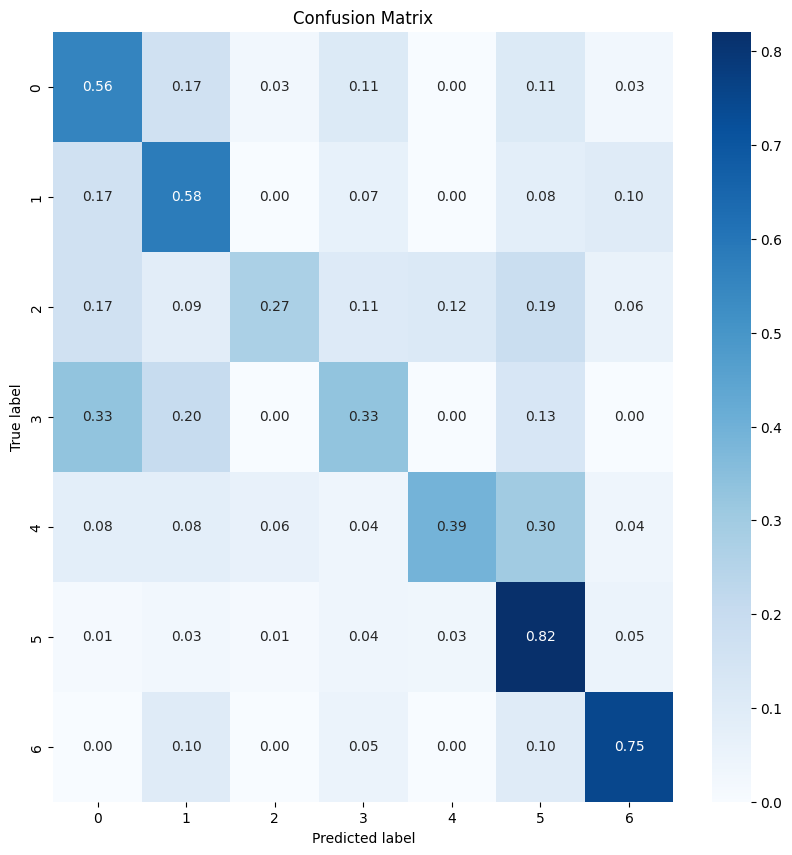

In [33]:
#check if the model is trained
model2.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(len(set(train_dataset.labels)))]))

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_true, y_pred, classes=list(set(train_dataset.labels)))

# Save the model
torch.save(model2.state_dict(), 'skin_cancer_model2.pth')

In [ ]:
#check if the model is trained
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"test Accuracy: {accuracy:.2f}%")

y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(len(set(train_dataset.labels)))]))

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_true, y_pred, classes=list(set(train_dataset.labels)))

# Save the model
torch.save(model.state_dict(), 'skin_cancer_model.pth')